# Imports and paths

In [1]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm
            
# Machine learning 
import lightgbm as lgb
import joblib
#from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, ValueFilloutTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

C:\Anaconda3\envs\eo_learn\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [39]:
# Folder where data for running the notebook is stored
DATA_FOLDER = 'N:\\CropInventoryAutomation\\Quebec\\training_data'

LOGS_FOLDER = os.path.join(DATA_FOLDER, 'logs')
if not os.path.isdir(LOGS_FOLDER):
    os.makedirs(LOGS_FOLDER)
    
land_cover_path = os.path.join(DATA_FOLDER, 'BDPPAD_v03_2018_train.shp')

path_out = os.path.join(DATA_FOLDER, 'eopatches')
if not os.path.isdir(path_out):
    os.makedirs(path_out)
    
path_out_sampled = os.path.join(DATA_FOLDER, 'eopatches_sampled')
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
    
model_base_name = 'model_100it_5class_all'
model_path = os.path.join(DATA_FOLDER, 'model', '{}.pkl'.format(model_base_name))

tiff_location = os.path.join(DATA_FOLDER, 'predicted_tiff')
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

# Part 1 - AOI

## 1- Define the Area-of-Interest (AOI):

### Get area boundary

POLYGON ((-74.50634648728041 45.68917035608803, -74.47383118679149 45.58534629981282, -74.38873198878188 45.54450205072496, -74.4972546144726 45.31971783908955, -74.40234449704027 45.19147853010994, -74.51378591727278 44.99830015436273, -71.50781406914339 45.01690434420657, -71.38735850483454 45.24867541621444, -71.29058631908872 45.29704951555745, -71.14389455234826 45.25181297580343, -71.01401360968956 45.33940929756098, -70.81809181992965 45.41080928292061, -70.77934900299343 45.4362740096877, -70.72278872770995 45.51129619334505, -70.53948926816356 45.67323751282573, -70.39121709861472 45.72880189099881, -70.40906922429902 45.8022717621751, -70.24641502625326 45.89304641685283, -70.27285179764215 46.21255796864437, -70.20147738229872 46.34742527729962, -70.04129797585308 46.42381620246084, -69.98916500839394 46.72017886185348, -69.66367311990392 47.02357188366658, -69.62058837013029 47.61589396090178, -69.82400790405939 47.62059360464129, -70.09508185976142 47.46177577832674, -70.1

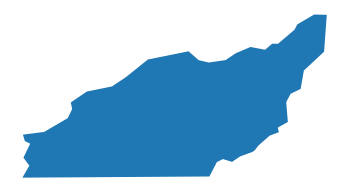

In [32]:
# Load geojson file
area = gpd.read_file(os.path.join(DATA_FOLDER, 'quebec_zone.geojson'))

# Convert CRS to UTM_18N
#area_crs = CRS.UTM_18N
area_crs = CRS.WGS84
area = area.to_crs(crs={'init': CRS.ogc_string(area_crs)})

# Get the area shape in polygon format
#area_shape = area.geometry.values.tolist()[-1]  # geopandas <= 0.6.0
area_shape = np.asarray(area.geometry)[-1]  # geopandas >= 0.6.0

# Plot area
area.plot()
plt.axis('off');

# Print size 
# print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(area_shape.bounds[2] - area_shape.bounds[0],
#                                                              area_shape.bounds[3] - area_shape.bounds[1]))

### Split to smaller tiles

In [33]:
# Create the splitter to obtain a list of bboxes
bbox_splitter = BBoxSplitter([area_shape], area_crs, (36,30))

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    patchIDs.append(idx)

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]

idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(area_crs)}, 
                       geometry=geometry)
# # save to shapefile
shapefile_name = os.path.join(DATA_FOLDER, 'quebec_eopatches.shp')
gdf.to_file(shapefile_name)

### Visualize the selection

In [34]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

,index_x,index_y,geometry
0,0,0,"POLYGON ((-74.51379 44.99830, -74.51379 45.085..."
1,0,1,"POLYGON ((-74.51379 45.08571, -74.51379 45.173..."
2,0,2,"POLYGON ((-74.51379 45.17312, -74.51379 45.260..."
3,0,3,"POLYGON ((-74.51379 45.26053, -74.51379 45.347..."
4,0,4,"POLYGON ((-74.51379 45.34794, -74.51379 45.435..."


(-74.7584457946299, -69.37592849277317, 44.8671854818488, 47.75170827715522)

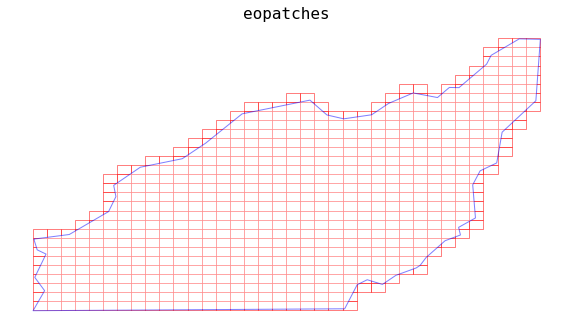

In [35]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 16}

# figure
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
area.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('eopatches', fontdict=fontdict);
plt.axis('off')

## 2- Fill EOPatches with data:

### Define some needed custom EOTasks

In [36]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is assumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_feature_name = band_a.split('/')[0]
        self.band_b_feature_name = band_b.split('/')[0]
        self.band_a_feature_idx = int(band_a.split('/')[-1])
        self.band_b_feature_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_feature_name][..., self.band_a_feature_idx]
        band_b = eopatch.data[self.band_b_feature_name][..., self.band_b_feature_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

### Define the workflow tasks

In [37]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B05, B06, B07, B8A, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
#     maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI = (SWIR – NIR) / (SWIR + NIR)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/7', 'BANDS/2')
# https://en.wikipedia.org/wiki/Normalized_difference_water_index
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/7')  # monitor changes related to water content in water bodies
#ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/7', 'BANDS/8')  # monitor changes in water content of leaves  
#ndbi = NormalizedDifferenceIndex('NDBI', 'BANDS/8', 'BANDS/7')  # Normalized Difference Built-up Index  
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

## 3- Add reference map

### Reference map task

In [38]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',                      'white')
    HAY                = (1,  'Hay',                        '#3366ff')  # blue
    CORN               = (2,  'Corn',                       '#ffff00')  # yellow
    SOY                = (3,  'Soy',                        '#ff33cc')  # pink
    WHEAT              = (4,  'Wheat',                      '#00ffff')  # teal
    OAT                = (5,  'Oat',                        '#ff6600')  # orange
    BARLEY             = (6,  'Barley',                     '#990000')  # brown/red
    VARIOUS_CROPS      = (7,  'Various crops',              '#66ff66')  # neon green
    OTHER              = (8,  'Other',                        'black')
    

    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# example usecase
# LULC.HAY.id   # return 1
        
# Reference colormap things
nb_class = 9
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, nb_class, 1), lulc_cmap.N)

In [40]:
%%time
# TASK FOR RASTERIZATION OF THE LAND COVER SHAPEFILE

land_cover_data = gpd.read_file(land_cover_path)

rasterization_task = VectorToRaster(land_cover_data, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='CROP_ID', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint8)

Wall time: 3min 17s


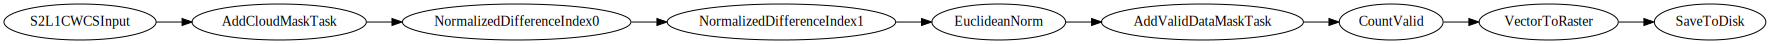

In [50]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [60]:
patchIDsTrain = [50, 152, 448, 614]
# patchIDsTrain = [50, 152, 161, 448, 614]

In [54]:
# define additional parameters of the workflow
execution_args = []

time_interval = ['2018-01-01', '2018-12-31']

for idx, bbox in enumerate(bbox_list[patchIDsTrain]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(patchIDsTrain[idx])}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)
executor.run(workers=1, multiprocess=False)  # just 1 worker so we don't exceed per minute trial limit

executor.make_report()

C:\Anaconda3\envs\eo_learn\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\envs\eo_learn\lib\site-packages\eolearn\geometry\transformations.py:163: RuntimeWarning: Given vector polygons contain some invalid geometries, they will be fixed
  warnings.warn('Given vector polygons contain some invalid geometries, they will be fixed', RuntimeWarning)
C:\Anaconda3\envs\eo_learn\lib\site-packages\eolearn\geometry\transformations.py:163: RuntimeWarning: Given vector polygons contain some invalid geometries, they will be fixed
  warnings.warn('Given vector polygons contain some invalid geometries, they will be fixed', RuntimeWarning)
C:\Anaconda3\envs\eo_learn\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\envs\eo_learn\lib\site-packages\eolearn\geometry\transformations.py:163: RuntimeWarning: Given vector polygons contain some invalid geometries, they will be fixe

# Part 2 - Training

## 5. Prepare the training data

We will create a new workflow that processes the data:

1. Remove too cloudy scenes
   * Check the ratio of the valid data for each patch and for each time frame
   * Keep only time frames with > 80 % valid coverage (no clouds)
2. Concatenate BAND, NDVI, NDWI, NORM info into a single feature called FEATURES
3. Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Create a task for linear interpolation in the temporal dimension
   * Provide the cloud mask to tell the interpolating function which values to update
4. Perform erosion
   * This removes artefacts with a width of 1 px, and also removes the edges between polygons of different classes
5. Random spatial sampling of the EOPatches
   * Randomly take a subset of pixels from a patch to use in the machine learning training
6. Split patches for training/validation
   * Split the patches into a training and validation set

### Define EOTasks

In [55]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [56]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2018-01-01', '2018-12-31', 16)

linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = int(8e4) # no. of pixels to sample
#n_samples = int(4e4) # no. of pixels to sample
ref_labels = list(range(nb_class)) # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples, 
    ref_mask_feature='LULC_ERODED', 
    ref_labels=ref_labels, 
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
    ])

save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

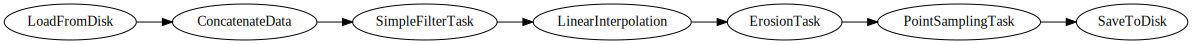

In [57]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)
# Let's visualize it
workflow.dependency_graph()

### Run the EOWorkflow over all EOPatches

In [58]:
%%time
   
execution_args = []
for idx in range(len(patchIDsTrain)):
    execution_args.append({
        load: {'eopatch_folder': 'eopatch_{}'.format(patchIDsTrain[idx])},
        save: {'eopatch_folder': 'eopatch_{}'.format(patchIDsTrain[idx])}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)
executor.run(workers=1, multiprocess=False)

executor.make_report()


Wall time: 1h 5min 1s


## 6. Model construction and training

The patches are split into a train and test subset, where we take the patch with ID = 1 for testing, since it seems a good representative of the area. 

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features (in this example 207), with $f$ the size of bands and band combinations (in this example 9) and $t$ the length of the resampled time-series (in this example 23)

[LightGBM](https://github.com/Microsoft/LightGBM) is used as a ML model. It is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for many machine learning tasks.

The default hyper-parameters are used in this example. For more info on parameter tuning, check the [ReadTheDocs](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) of the package.

In [61]:
# load sampled eopatches
eopatches = []

for i in range(len(patchIDsTrain)):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, patchIDsTrain[i]), lazy_loading=True))    

eopatches = np.array(eopatches)

In [62]:
%%time
    
# Definition of the train and test patch IDs
# train_ID = list(range(0, 49))
# test_ID = [5, 6, 12, 13, 20]
# for i in test_ID:
#     train_ID.remove(i)
train_ID = [0, 1, 2]
test_ID = [3]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]

Wall time: 1min 8s


### Set up and train the model
https://lightgbm.readthedocs.io/en/latest/Parameters.html

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [63]:
%%time

model_base_name = 'model_QC_100it'
model_path = os.path.join(DATA_FOLDER, '{}.pkl'.format(model_base_name))

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(labels_unique),
    # Metric parameters
    metric='multi_logloss',  # loss for multi classification
    # Core parameters
    #boosting='rf',
    num_iterations=100,  # Int (default=100); Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    #learning_rate=0.1,  # Double (default=0.1); Determines the impact of each tree on the final outcome; Typical values: 0.1, 0.001, 0.003...
    #num_leaves=31,  # Int (default=31); Max number of leaves in one tree
    # Control parameters
    #feature_fraction=0.8,  # Double (default=1) 0.0 < feature_fraction <= 1.0; used when boosting_type='rf'
    #bagging_fraction=0.7,  # Double (default=1) 0.0 < bagging_fraction <= 1.0; can be used to speed up training and deal with over-fitting; need bagging_freq>=1
    #bagging_freq=1,  # Int (default=0); 0 means disable bagging; k means perform bagging at every k iteration; need bagging_fraction<1 aswell
    #max_depth=-1,  # Int (default=-1); <= 0 means no limit; limit the max depth for tree model. This is used to deal with over-fitting when data is small
    #min_data_in_leaf=20,  # Int (default=20); minimal number of data in one leaf. Can be used to deal with over-fitting
   # early_stopping_round=10,  # Int (default=0); will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds
    # IO parameters
    #max_bin=500,  # Default 255, use larger number for more accuracy; smaller number to deal with over-fitting
    #save_binary=True  # For dealing with the memory size of your data file then specify this parameter as ‘True’
)

# train the model
model.fit(features_train, labels_train)
# uncomment to save the model
joblib.dump(model, model_path)

Wall time: 3min 23s


['N:\\CropInventoryAutomation\\Quebec\\training_data\\model_QC_100it.pkl']

## 7. Validation

Validation of the model is a crucial step in data science. All models are wrong, but some are less wrong than others, so model evaluation is important.

In order to validate the model, we use the training set to predict the classes, and then compare the predicted set of labels to the "ground truth".

Unfortunately, ground truth in the scope of EO is a term that should be taken lightly. Usually, it is not 100 % reliable due to several reasons:

* Labels are determined at specific time, but land use can change (_what was once a field, may now be a house_)
* Labels are overly generalized (_a city is an artificial surface, but it also contains parks, forests etc._)
* Some classes can have an overlap or similar definitions (_part of a continuum, and not discrete distributions_)
* Human error (_mistakes made when producing the reference map_)

The validation is performed by evaluating various metrics, such as accuracy, precision, recall, $F_1$ score, some of which are nicely described [in this blog post](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)

In [64]:
# uncomment to load the model and replace with your file, usually just correct the date
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

Get the overall accuracy (OA) and the weighted $F_1$ score

In [65]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 67.9%
Classification F1-score 59.5%


$F_1$ score, precision, and recall for each class separately

In [66]:
class_labels = np.unique(labels_test)
class_names = [entry.class_name for entry in LULC]

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 
print('             Class                        =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:30s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class                        =  F1  | Recall | Precision
         --------------------------------------------------
         * Hay                            = 20.3 |  11.5  | 85.1
         * Corn                           = 61.8 |  62.1  | 61.5
         * Soy                            = 46.6 |  73.7  | 34.1
         * Wheat                          = 26.0 |  15.9  | 70.8
         * Oat                            = 0.0 |  0.0  | 0.0
         * Barley                         = 5.5 |  2.9  | 63.0
         * Various crops                  = 2.3 |  2.0  | 2.8
         * Other                          = 82.4 |  99.5  | 70.3


### Plot the standard and transposed Confusion Matrix

In [68]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 #color="white" if cm[i, j] > thresh else "black",
                 color = "red",
                 fontsize=22)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

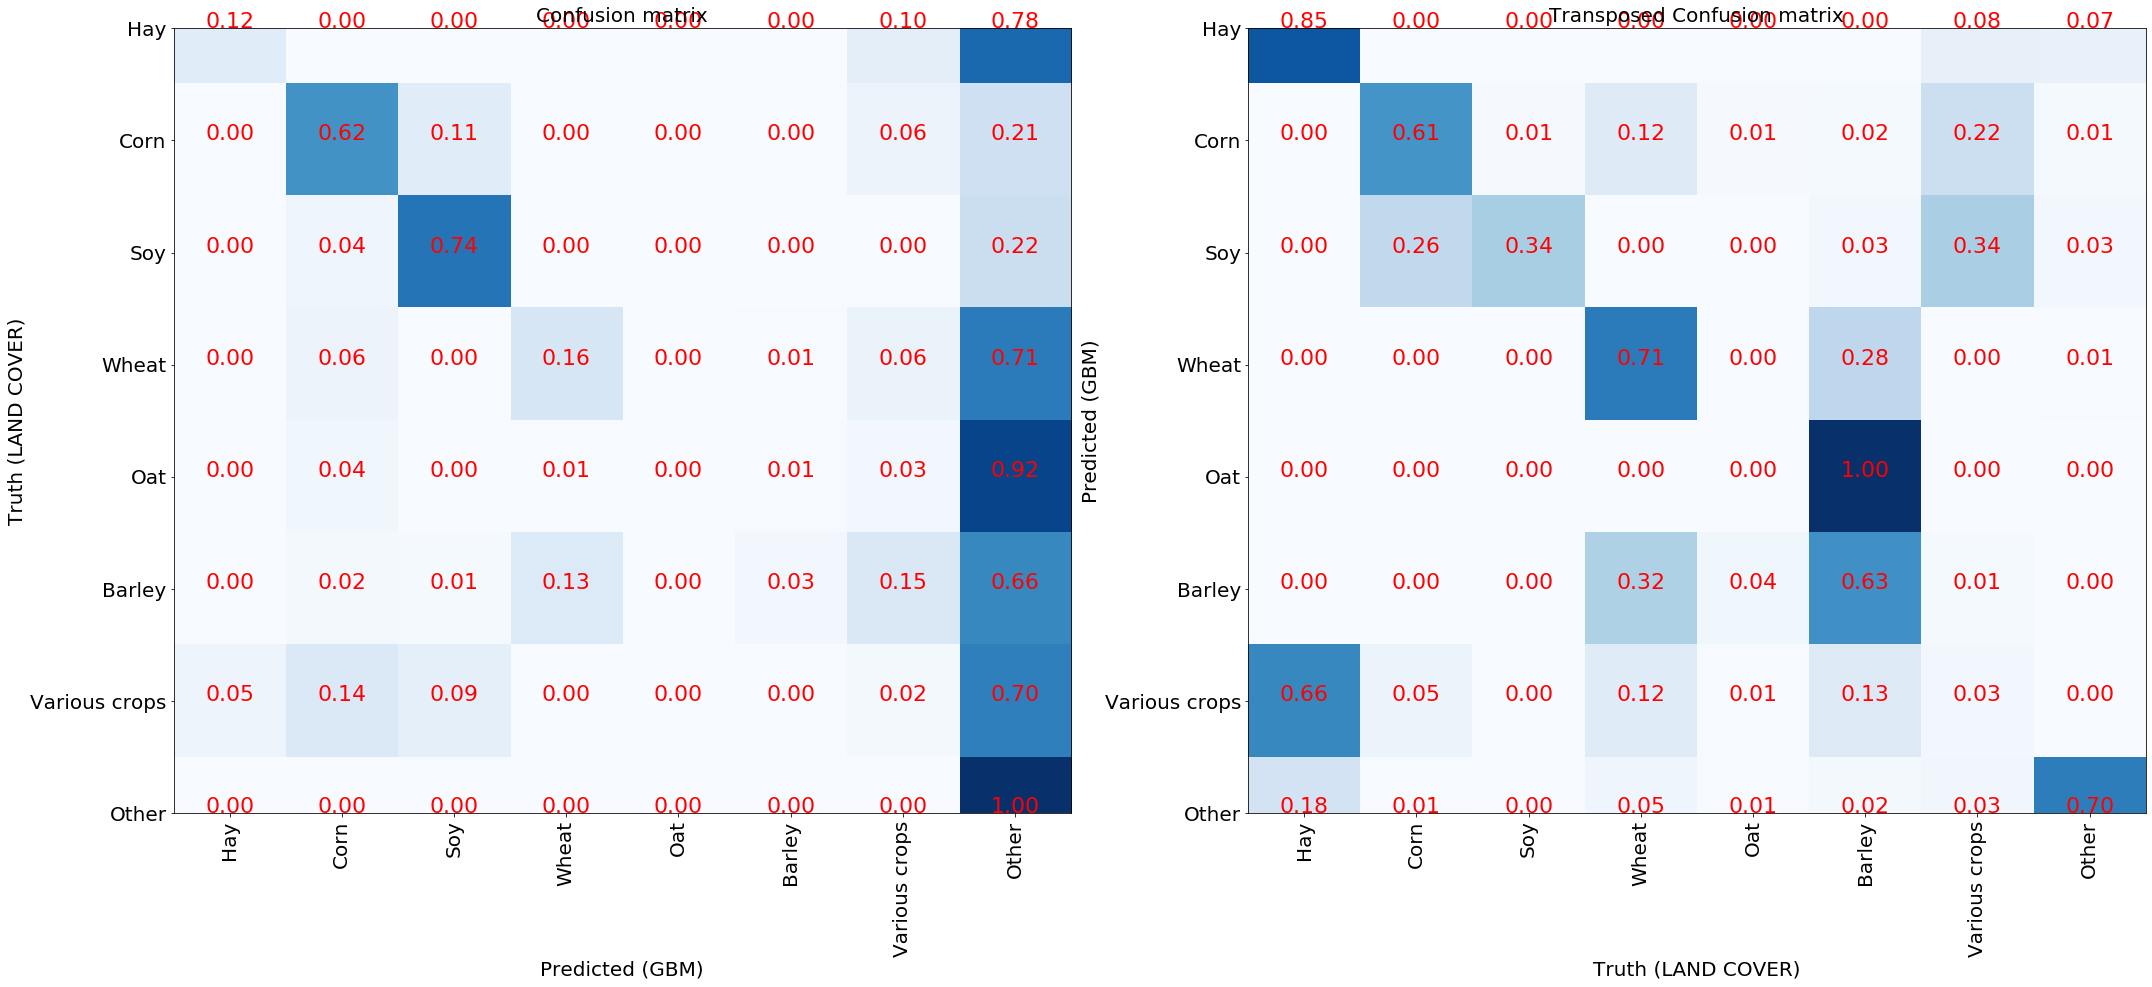

In [69]:
fig = plt.figure(figsize=(30, 30))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (LAND COVER)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

For some of the classes the model seems to perform well. Otherwise the training sample is probably too small to make a fair assesment. 
Additional problems arise due to the unbalanced training set. The image below shows the frequency of the classes used for model training, and we see that the problematic cases are all the under-represented classes: shrubland, bareland and hay. 

Improving the reference map would also affect the end result, as, for example some classes are mixed up to some level.

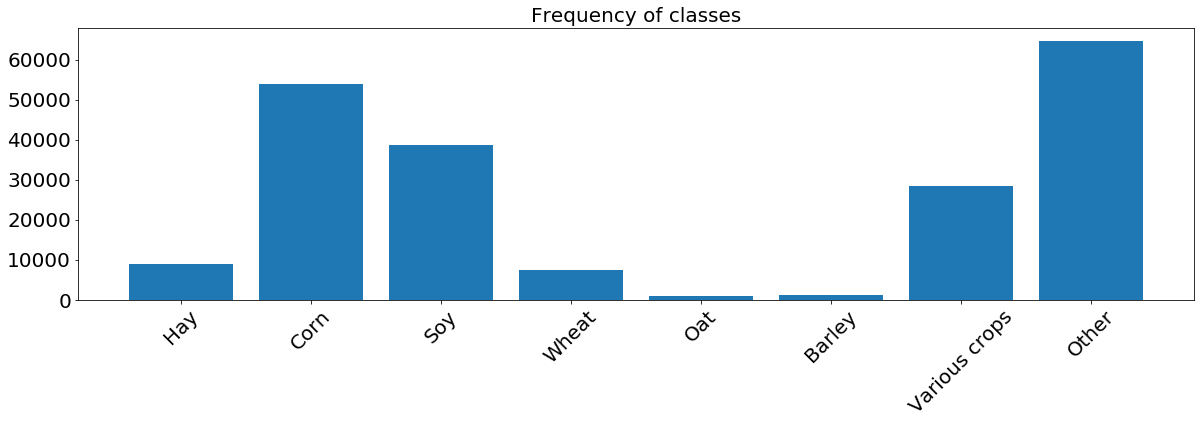

In [67]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)
plt.title('Frequency of classes', fontsize=20)
plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

### ROC curves and AUC metrics

Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [70]:
class_labels = np.unique(np.hstack([labels_test, labels_train]))

scores_test = model.predict_proba(features_test)
labels_binarized = preprocessing.label_binarize(labels_test, classes=class_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx]) 

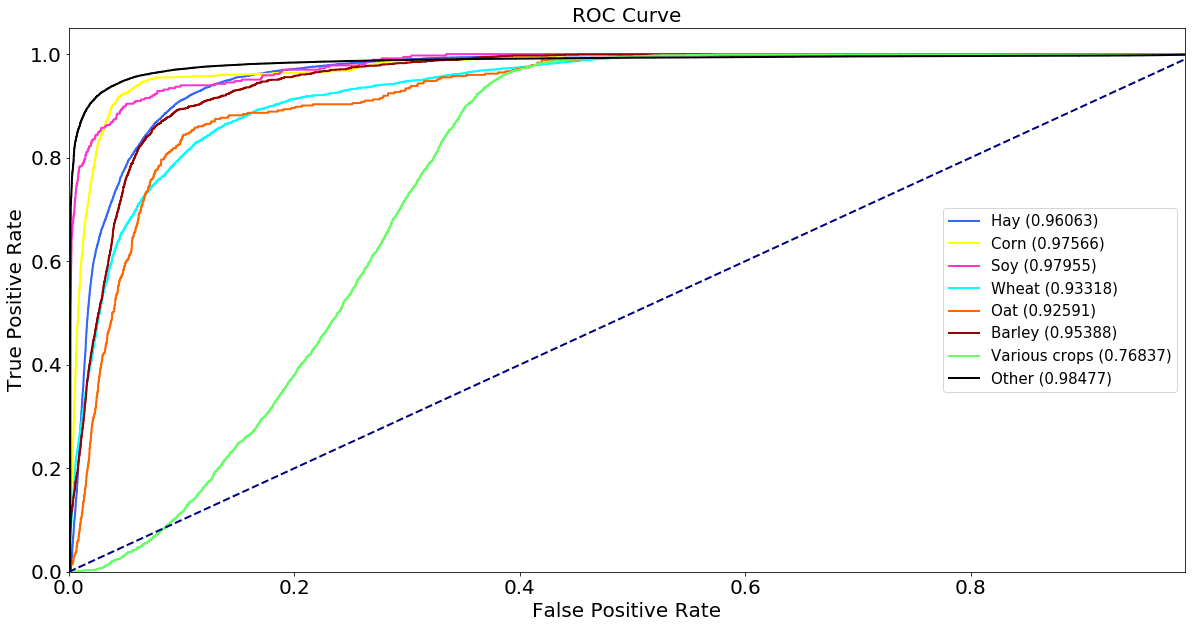

In [71]:
plt.figure(figsize=(20, 10))

for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx], color=lulc_cmap.colors[lbl],
         lw=2, label=class_names[lbl] + ' (%0.5f)' % roc_auc[idx])
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="center right", prop={'size': 15})
plt.show()

### Most important features

Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them. 

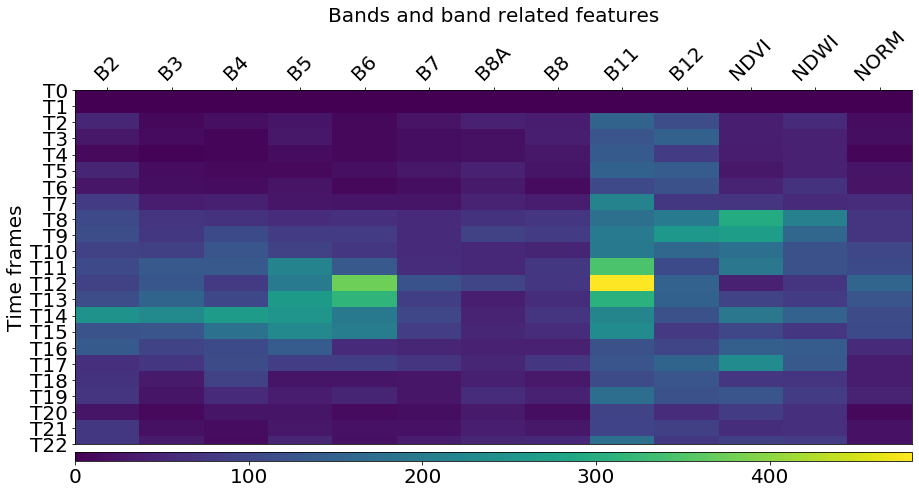

In [72]:
# names of features
fnames = ['B2','B3','B4','B5','B6','B7','B8A','B8','B11','B12','NDVI','NDWI','NORM']

# get feature importances and reshape them to dates and features
z = model.feature_importances_.reshape((t, f))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(t), ['T{}'.format(i) for i in range(t)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
# plt.colorbar(im, cax=cax)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 

## 8. Visualization of the results

The model has been validated, the remaining thing is to make the prediction on the whole AOI.

Here we define a workflow to make the model prediction on the existing EOPatces. The EOTask accepts the features and the names for the labels and scores. The latter is optional.

### Define EOTasks

In [17]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, t * f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return eopatch

### Define Tasks and the Workflow

In [18]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out_sampled)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# TASK FOR CLEANING SPECKLES
#clean_speckles = ValueFilloutTask('LBL_GBM') 
#ValueFilloutTask(feature=(FeatureType.DATA,'FEATURES'), operations='fb', value=np.nan, axis=0)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
    
# TASK FOR SAVING
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
#save = SaveToDisk('./eopatches_sampled_small1/', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)

### Run the prediction and export to GeoTIFF images

Here we use the `EOExecutor` to run the workflow in parallel.

In [20]:
%%time
# create a list of execution arguments for each patch
execution_args = []
random_patch = test_ID[0]
print(test_ID)
execution_args.append({load: {'eopatch_folder': 'eopatch_{}'.format(random_patch)},
                       export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, random_patch)},
                       save: {'eopatch_folder': 'eopatch_{}'.format(random_patch)}})

# for i in range(len(patchIDs)):
#     execution_args.append(
#         {
#             load: {'eopatch_folder': 'eopatch_{}'.format(i)},
#             export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, i)},
#             save: {'eopatch_folder': 'eopatch_{}'.format(i)}
#         }
#     )

# run the executor on 2 cores
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)

executor.run(workers=2, multiprocess=False)
executor.make_report()

[8]



Wall time: 10min 25s


### Visualise the prediction

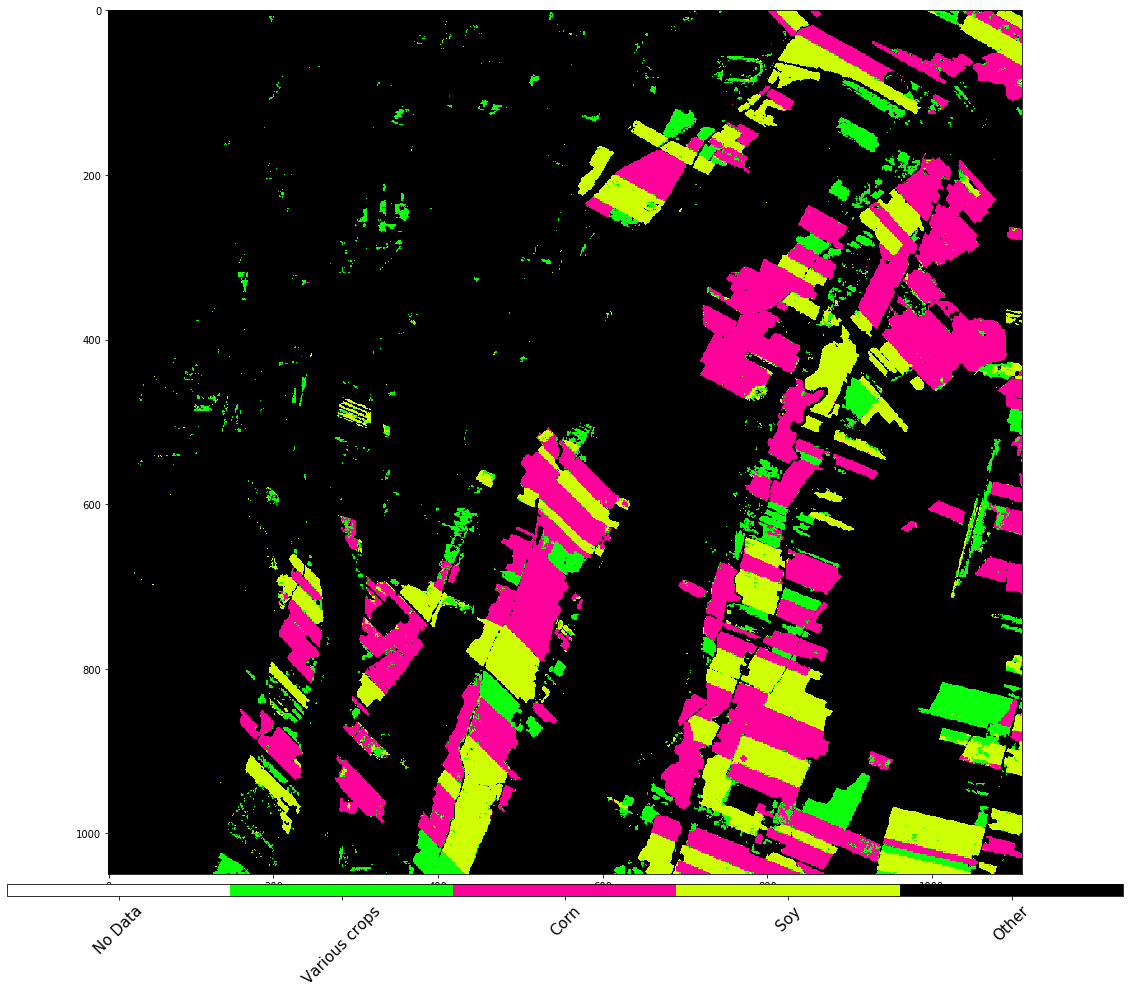

In [21]:
fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=1, ncols=1)

eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, random_patch), lazy_loading=True)
im = axes.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("auto")
    
    
# pbar = tqdm(total=9)
# for i, ax in enumerate(axes.flat):
#     eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True)
#     im = ax.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_aspect("auto")
#     pbar.update(1)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

### Visual inspection of patches

Here is just a simple piece of code that allows a closer inspection of the predicted labels. 

Random subsets of patches are chosen, where prediction and ground truth are compared. For visual aid the mask of differences and the true color image are also provided.

In majority of the cases, differences seem to lie on the border of different structures.

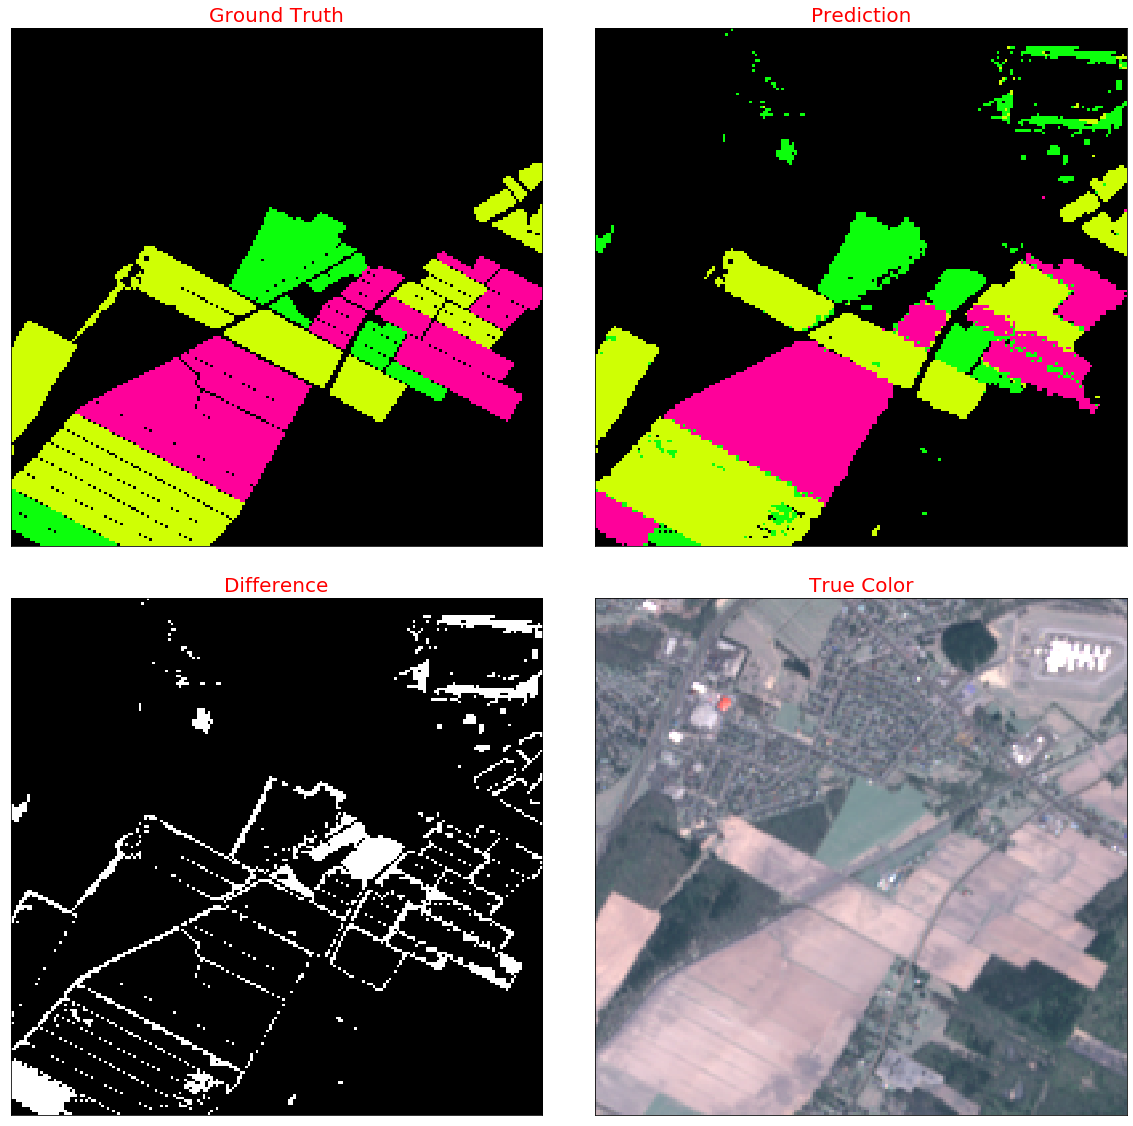

In [25]:
# Draw the Reference map

fig = plt.figure(figsize=(20, 20))

idx = np.random.choice(range(9))
inspect_size = 200

eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, random_patch), lazy_loading=True)

w, h = eopatch.mask_timeless['LULC'].squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
h_min = np.random.choice(range(h - inspect_size))

ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless['LULC'].squeeze()[w_min: w_min + inspect_size, h_min : h_min + inspect_size],
           cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=20, color='r')

ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze()[w_min: w_min + inspect_size, h_min: h_min + inspect_size],
           cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=20, color='r')

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless['LBL_GBM'].squeeze() != eopatch.mask_timeless['LULC'].squeeze()
plt.imshow(mask[w_min: w_min + inspect_size, h_min: h_min + inspect_size], cmap='gray')
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('Difference', fontsize=20, color='r')

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data['FEATURES'][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min: w_min + inspect_size, h_min: h_min + inspect_size])
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('True Color', fontsize=20, color='r')

fig.subplots_adjust(wspace=0.1, hspace=0.1)